In [29]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

data = pd.read_csv("fec_itoth_2004_transam_posdig.csv", sep='|')

In [30]:
data.head()
data.shape

cmte_id amndt_ind rpt_tp transaction_pgi    image_num transaction_tp  \
0  C00370759         N     Q3               G  24962480744            24Z   
1  C00357897         A     Q2               G  24962466213            24Z   
2  C00045781         A     Q2               G  24971453792            24Z   
3  C00045781         A     Q2               P  24971453794            24Z   
4  C00045781         A     Q2               P  24971453794            24Z   

  entity_tp                                name            city state  ...  \
0       CAN                  ANDREWS, ROBERT E.  HADDON HEIGHTS    NJ  ...   
1       ORG  PHIL STEFANI SIGNATURE RESTAURANTS         CHICAGO    IL  ...   
2       ORG                            116 CLUB      WASHINGTON    DC  ...   
3       ORG                             DIXON'S          DENVER    CO  ...   
4       ORG                             DIXON'S          DENVER    CO  ...   

   occupation transaction_dt transaction_amt   other_id             tran_id  \
0         NaN        9282004             249  C00243428  DISB00000159DBR001   
1         NaN        6052004            1000  C00381442           SB23.4136   
2         NaN        5172004             389  C00199273           SB23.5938   
3         NaN        6012004              54  C00376152           SB23.5951   
4         NaN        5142004             100  C00376152           SB23.5936   

   file_num memo_cd             memo_text               sub_id first_dig_amt  
0  140188.0       X  IN-KIND CONTRIBUTION  4102020041043811352             2  
1  139613.0     NaN                   NaN  4101920041043764213             1  
2  134693.0     NaN                   NaN  4091520041042263761             3  
3  134693.0     NaN                   NaN  4091520041042263768             5  
4  134693.0     NaN                   NaN  4091520041042263767             1  

[5 rows x 22 columns]

(8137, 22)

In [31]:
data['transaction_amt'].describe()

count     8137.000000
mean       555.502151
std       1749.825951
min          1.000000
25%         67.000000
50%        196.000000
75%        500.000000
max      83726.000000
Name: transaction_amt, dtype: float64

In [32]:
# Recast amt_first_digit from text to integer
first_digits = data.loc[:,'first_dig_amt'].astype(int)
first_digits.describe()

count    8137.000000
mean        3.830773
std         2.725566
min         1.000000
25%         2.000000
50%         3.000000
75%         5.000000
max         9.000000
Name: first_dig_amt, dtype: float64

<AxesSubplot:>

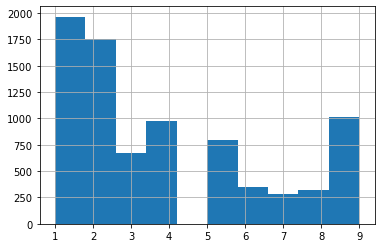

In [33]:
# Now I need to report the frequencies of each of the amt_first digits
# First, get the counts of each digit from 0 through 9
first_digits.hist()
# I wish I could get the histogram for Benford's law data

In [34]:
first_digit_counts = first_digits.value_counts().sort_index()
first_digit_counts
first_digit_counts.keys()

1    1966
2    1757
3     675
4     975
5     792
6     348
7     287
8     324
9    1013
Name: first_dig_amt, dtype: int64

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64')

In [35]:
# Now get the total number of rows
total_rows = len(data)
first_digit_freq = first_digit_counts/total_rows

In [36]:
# Create Benford's limiting order distribution as a series
benfordd = pd.Series([0.30103,0.17609, 0.12494, 0.09691, 0.07918, 0.06995, 0.05799, 0.05115, 0.04576], index=range(1,10))

# [Goodness of Fit Tests](https://www.statisticshowto.com/goodness-of-fit-test/)
## [Chi-Squared Test](https://www.statisticshowto.com/probability-and-statistics/chi-square/)
First, I need to use the total number of rows to calculate the expected number of counts for each digit from Benford's distribution (expected) and compare it to first_digit_counts (observed).
The null hypothesis is that the 2018 cycle campaign finance data does follow Benford's distribution. <br>
The alternative hypothesis is that the 2018 cycle campaign finance data does not follow Benford's distributino.

In [37]:
import scipy.stats as stats

In [38]:
nrows = data.shape[0]
expected = benfordd*nrows

In [39]:
# source: https://stackoverflow.com/questions/27663924/printing-2-evenly-populated-lists-side-by-side-evenly/27663989
fmt = '{:<8}{:<20}{}'

print(fmt.format('', 'Expected', 'Observed'))
for i, (ben, cyc) in enumerate(zip(expected, first_digit_counts)):
    print(fmt.format(i, ben, cyc))

        Expected            Observed
0       2449.48111          1966
1       1432.84433          1757
2       1016.6367799999999  675
3       788.5566699999999   975
4       644.28766           792
5       569.18315           348
6       471.86463           287
7       416.20755           324
8       372.34912           1013


In [40]:
stats.chisquare(f_obs=first_digit_counts, f_exp=expected)

Power_divergenceResult(statistic=1642.6032161053877, pvalue=0.0)

The Chi-squared statistic is 62.17 and the corresponding p-value is 1.74e-10 (basically zero). Since the p-value is less than 0.05, we reject the null hypothesis and claim that the 2018 cycle data do not follow Benford's distribution.
I need to come back and double check this!! It's very odd that the p-value is low when it appears to fit Benford's distribution so well. I should read stats.chisquare documentation more, check that my degrees of freedom are correct, and/or look at [this post](https://stackoverflow.com/questions/42888962/chi-squared-goodness-of-fit-test-in-python-way-too-low-p-values-but-the-fittin) <br>
Ahh, I should come back to it after I have all the proper data. According to Cho & Gaines on p. 220 "$\chi^2$ tests are very sensitive to sample size, having enormous power for large *N*, so that even quite small differences will be statistically significant. This test appears to be too rigid to assess goodness-of-fit well, especially since the Benford proportions do not represent a true distribution that one would expect to occur in the limit (Ley 1996; Giles 2007)."

In [41]:
fig, ax = plt.subplots()
ax.plot(first_digit_counts, '--r', label='2004 Cycle')
ax.plot(expected, '-b', label='Benford''s distribution')
leg = ax.legend()

Graphically, the relationship between Benford's distribution and the committee-to-committee in-kind contributions in just 2003 to 2004 data that I pulled looks pretty identical to the graph that Dr. Cho and Dr. Gaines produced in their paper. From the dip at 3, to the spike at 4, and dip from 6 to 8 below Benford's distribution, and the sharp spike at 9, they are the same, even though I'm missing a few dozen records that they had.

In [42]:
first_digit_freq

1    0.241612
2    0.215927
3    0.082954
4    0.119823
5    0.097333
6    0.042768
7    0.035271
8    0.039818
9    0.124493
Name: first_dig_amt, dtype: float64

The distribution that Dr. Cho and Dr. Gaines found for the 2004 election cycle was as follows:

| First Digit | 2004 |
| --- | --- |
| 1 | 23.3 |
| 2 | 21.1 |
| 3 | 8.5 |
| 4 | 11.7 |
| 5 | 9.5 |
| 6 | 4.2 |
| 7 | 3.7 |
| 8 | 4.0 |
| 9 | 14.1 |

Matching the graph, the actual relative frequencies I found for the first digits in the 2004 data are pretty close to the ones that Cho and Gaines had. The most deviating digit is 9, where I had 12.4% and they had 14.1%, but it's still not that far off. The rest - 24.6% vs 23.3% for 1, 21.6% vs 21.1% for 2, 8.3% vs 8.5% for 3, and so on, are very close, considering that I have most of the data they had.